In [169]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv

In [170]:
class Location:
    def __init__(self, name=None, distance=None):
        self.name = name
        self.distance = distance

In [171]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance, p, counter, boat_list, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        #self.location.distance = distance[' '.join(self.location.name)]
        self.location.distance = distance[self.location.name]

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        print('%7.4f Call %d received from %s at a distance of %d' % (env.now, self.ID, self.location.name, 
                                                                      self.location.distance))
        
        with counter.request() as req:
            yield req
            wait = env.now - self.initial_time #waiting time 
            print('%7.4f Call %d: Waited %6.3f' % (env.now, self.ID, wait))
            yield env.process(trajet(env, boat_list, self, wait))
            print('%7.4f Call %d: Finished' % (env.now, self.ID))

        self.status = 1
        

In [172]:
def trajet(env, boat_list, call, wait): 
    i = 0 
    while(i != len(boat_list) and boat_list[i].status != 0): #while you don't have a boat available 
        i = i + 1
    if(i != len(boat_list) and boat_list[i].status == 0): #if you have a boat available
        boat_list[i].status = 1 
        intervention = Intervention()
        print('Boat {} with a speed of {} respond to the call {} '.format(boat_list[i].ID, boat_list[i].speed, call.ID))
        intervention.boat = boat_list[i]
        intervention.call = call
        intervention.travel_time = call.location.distance/boat_list[i].speed
        intervention.TOS = 0.25
        intervention.waited_time = wait 
        intervention.response_time = intervention.travel_time + wait 
        intervention.road_time = 2*intervention.travel_time + intervention.TOS 
        inter_list.append(intervention)
        yield env.timeout(intervention.road_time)
        call.final_time = call.initial_time + intervention.road_time 
        print('Duration of the intervention {} : {} '.format(intervention.ID, intervention.road_time))
        boat_list[i].status = 0
    

In [173]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat = boat
        self.call = call
        
    def to_dict(self): 
        return {
            'ID intervention': self.ID,
            'Boat associated': self.boat.ID,
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'Time On Scene': self.TOS,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [174]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 

In [175]:
def source(env, counter, p, boat_list, call_list): 
    yield env.timeout(0)
    print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance, p, counter, boat_list))
        else: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance, p, counter, boat_list, call_list[i-1]))

In [176]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':100, 'N SRA P. SOCORRO':90, 'BONSUCESSO':80, 'ASS. NAZARE':70, 'GUAJARA':60, 
            'ARUAU':100, 'MIPINDIAU':90, 'CUIEIRAS':75, 'SANTA MARIA':60, 'JARAQUI':52, 'COSTA DOS ARARAS':50, 
            'COSTA DO TATU':30, 'AGROVILA':20, 'N. SRA. FATIMA':15, 'LIVRAMENTO':15}
nb_boat = 1
nb_call = 164
coeff_call = 4
inter_list = []
call_list = []
boat_list = []

In [177]:
#Setup and lauch of the simulation 

env = simpy.Environment()
# np.random.seed(42)
# random.seed(42)
for i in range(nb_boat): 
    boat_list.append(Boat(env,46,0))
    #boat_list.append(Boat(env,30,0))
counter = simpy.Resource(env, capacity=nb_boat)
env.process(source(env, counter, p_2015, boat_list, call_list))
env.run()

print ("list of intervention")
for inter in inter_list: 
    print("Intervention {} : for call {} with boat {} take {} ".format(inter.ID, inter.call.ID, inter.boat.ID, inter.road_time))

 0.0000 Start
 3.3948 Call 1 received from N SRA P. SOCORRO at a distance of 90
 3.3948 Call 1: Waited  0.000
Boat 1 with a speed of 46 respond to the call 1 
 3.6064 Call 2 received from AGROVILA at a distance of 20
Duration of the intervention 1 : 4.163043478260869 
 7.5579 Call 1: Finished
 7.5579 Call 2: Waited  3.951
Boat 1 with a speed of 46 respond to the call 2 
Duration of the intervention 2 : 1.1195652173913042 
 8.6774 Call 2: Finished
15.9912 Call 3 received from ARUAU at a distance of 100
15.9912 Call 3: Waited  0.000
Boat 1 with a speed of 46 respond to the call 3 
19.1186 Call 4 received from ARUAU at a distance of 100
Duration of the intervention 3 : 4.5978260869565215 
20.5891 Call 3: Finished
20.5891 Call 4: Waited  1.470
Boat 1 with a speed of 46 respond to the call 4 
Duration of the intervention 4 : 4.5978260869565215 
25.1869 Call 4: Finished
31.9131 Call 5 received from MIPINDIAU at a distance of 90
31.9131 Call 5: Waited  0.000
Boat 1 with a speed of 46 respond 

In [178]:
with open('intervention.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID_intervention', 'boat_associated', 'call_traited', 'travel_time', 'response_time', 'time_on_scene', 'waited_time', 'total_time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, dialect='excel', delimiter=';')

    writer.writeheader()
    for inter in inter_list: 
        writer.writerow({'ID_intervention': inter.ID, 'boat_associated': inter.boat.ID, 'call_traited': inter.call.ID, 
                        'travel_time': inter.travel_time, 'response_time': inter.response_time, 'time_on_scene': inter.TOS,
                        'waited_time': inter.waited_time, 'total_time': inter.road_time})

In [179]:
df = pd.DataFrame.from_records([inter.to_dict() for inter in inter_list])
df 

,Boat associated,Call location,Call traited,ID intervention,Time On Scene,response time,total time,travel time,waited time
0,1,N SRA P. SOCORRO,1,1,0.25,1.956522,4.163043,1.956522,0.000000
1,1,AGROVILA,2,2,0.25,4.386253,1.119565,0.434783,3.951471
2,1,ARUAU,3,3,0.25,2.173913,4.597826,2.173913,0.000000
3,1,ARUAU,4,4,0.25,3.644394,4.597826,2.173913,1.470481
4,1,MIPINDIAU,5,5,0.25,1.956522,4.163043,1.956522,0.000000
5,1,CUIEIRAS,6,6,0.25,5.386692,3.510870,1.630435,3.756257
6,1,COSTA DO TATU,7,7,0.25,3.517451,1.554348,0.652174,2.865277
7,1,CUIEIRAS,8,8,0.25,1.630435,3.510870,1.630435,0.000000
8,1,CUIEIRAS,9,9,0.25,4.028975,3.510870,1.630435,2.398541
9,1,COSTA DOS ARARAS,10,10,0.25,1.086957,2.423913,1.086957,0.000000


In [180]:
print(df["total time"].mean())
print(df["waited time"].mean())

2.859756097560974
5.088886050864299


In [181]:
df.to_csv('test.csv', sep = ";")

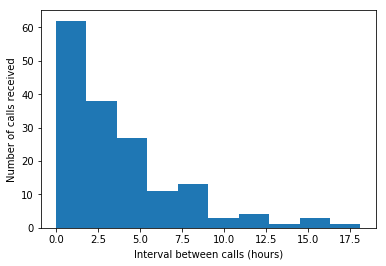

In [182]:
gaps = []
gaps.append(call_list[0].initial_time)
for i in range (1,len(call_list)-1):
    gaps.append(call_list[i].initial_time-call_list[i-1].initial_time)
    
plt.hist(gaps)
plt.xlabel('Interval between calls (hours)')
plt.ylabel('Number of calls received')
plt.show()